In [1]:
#Matthew Dobbin
#15th November 2018
#MSDS458 Artificial Intelligence
#Assignment 3 Recurrent Neural Networks
#Reuters data set loading, exploration and MLP model adapted from
#Deep learning with Python textbook authored by Francois Chollet

In [8]:
#Import Reuters dataset, restricts the data to the
#10,000 most frequently occuring words found in the data.
import keras
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

#Distribution of training and test data set
print(len(train_data), 'train sequences')
print(len(test_data), 'test sequences')

#Print undecoded newswire
print(train_data[15])

#Decodes the newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[15]])
print(decoded_newswire)

8982 train sequences
2246 test sequences
[1, 577, 9, 355, 430, 21, 4, 2222, 5, 4, 83, 181, 73, 418, 171, 1694, 3048, 202, 4596, 11, 15, 6, 750, 4193, 35, 7, 4, 121, 273, 94, 160, 4, 248, 409, 60, 5, 73, 418, 8, 348, 3048, 430, 202, 4073, 11, 15, 6, 566, 158, 35, 577, 910, 335, 6125, 333, 32, 1019, 35, 15, 6, 4459, 557, 35, 232, 218, 377, 563, 55, 772, 6, 30, 1177, 21, 712, 17, 12]
? commercial and industrial loans on the books of the 10 major new york banks excluding acceptances fell 572 mln dlrs to 64 297 billion in the week ended march 11 the federal reserve bank of new york said including acceptances loans fell 475 mln dlrs to 65 16 billion commercial paper outstanding nationally increased 2 98 billion dlrs to 339 00 billion national business loan data are scheduled to be released on friday reuter 3


In [14]:
# Vectorize the data
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

#Vectorize labels
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(x_train.shape)
print(x_test.shape)
print(one_hot_train_labels.shape)

(8982, 10000)
(2246, 10000)
(8982, 46)


Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 3s 321us/step - loss: 2.4410 - acc: 0.5245 - val_loss: 1.6799 - val_acc: 0.6371
Epoch 2/10
8982/8982 [==============================] - 2s 223us/step - loss: 1.3727 - acc: 0.7030 - val_loss: 1.3401 - val_acc: 0.7048
Epoch 3/10
8982/8982 [==============================] - 2s 220us/step - loss: 1.0467 - acc: 0.7751 - val_loss: 1.1668 - val_acc: 0.7311
Epoch 4/10
8982/8982 [==============================] - 2s 205us/step - loss: 0.8237 - acc: 0.8263 - val_loss: 1.0530 - val_acc: 0.7676
Epoch 5/10
8982/8982 [==============================] - 2s 198us/step - loss: 0.6538 - acc: 0.8612 - val_loss: 0.9987 - val_acc: 0.7689
Epoch 6/10
8982/8982 [==============================] - 2s 214us/step - loss: 0.5201 - acc: 0.8893 - val_loss: 0.9784 - val_acc: 0.7765
Epoch 7/10
8982/8982 [==============================] - 2s 199us/step - loss: 0.4239 - acc: 0.9112 - val_loss: 0.9361 - val_acc: 0.7912


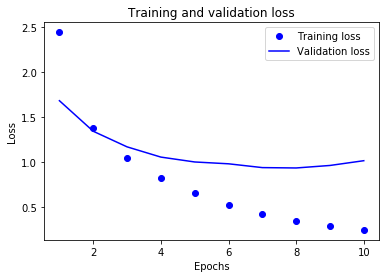

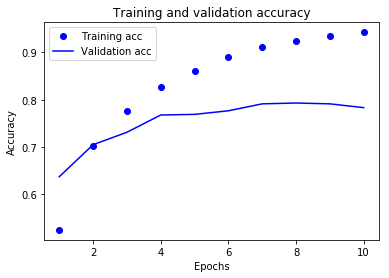

In [17]:
#Multilayer Perceptron Neural Network Model
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
import time
time_start=time.clock()

#Train the model
history = model.fit(x_train, one_hot_train_labels, epochs=10, batch_size=512, 
                    validation_data=(x_test, one_hot_test_labels))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot model
#from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='MLPmodel.png')


In [1]:
#Classification using word embeddings and Recurrent neural networks.
#Padding of sequences and SimpleRNN model code adapated from 
#https://github.com/cmhjerry/DeepLearningMC/blob/master/RNN%20Mini%20Project.ipynb

from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.utils import np_utils
import numpy as np
from keras import models
from keras import layers

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 64

print('Loading data...')
(input_train, y_train), (input_test, y_test) = reuters.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train = np_utils.to_categorical(y_train, 46)
y_test = np_utils.to_categorical(y_test, 46)

C:\Users\mkdob\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading data...
8982 train sequences
2246 test sequences
Pad sequences (samples x time)
input_train shape: (8982, 500)
input_test shape: (2246, 500)
y_train shape: (8982,)
y_test shape: (2246,)


Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 78s 9ms/step - loss: 2.4682 - acc: 0.3525 - val_loss: 2.4419 - val_acc: 0.3602
Epoch 2/10
8982/8982 [==============================] - 86s 10ms/step - loss: 2.0975 - acc: 0.4645 - val_loss: 2.0996 - val_acc: 0.4684
Epoch 3/10
8982/8982 [==============================] - 82s 9ms/step - loss: 1.7090 - acc: 0.5752 - val_loss: 2.2007 - val_acc: 0.4684
Epoch 4/10
8982/8982 [==============================] - 84s 9ms/step - loss: 1.2527 - acc: 0.6921 - val_loss: 2.1900 - val_acc: 0.4947
Epoch 5/10
8982/8982 [==============================] - 82s 9ms/step - loss: 0.9175 - acc: 0.7739 - val_loss: 2.3247 - val_acc: 0.4742
Epoch 6/10
8982/8982 [==============================] - 74s 8ms/step - loss: 0.6773 - acc: 0.8357 - val_loss: 2.4847 - val_acc: 0.4782
Epoch 7/10
8982/8982 [==============================] - 73s 8ms/step - loss: 0.5087 - acc: 0.8833 - val_loss: 2.4594 - val_acc: 0.4969
Epoch 

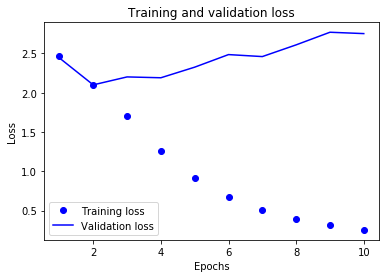

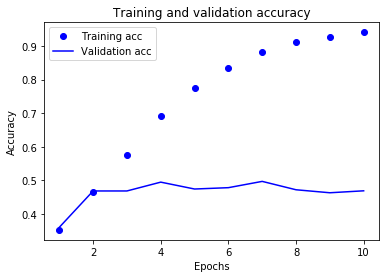

In [20]:
#Recurrent Neural Network Model (SimpleRNN)
from keras.layers import SimpleRNN, Embedding, Dense
model = models.Sequential()
model.add(Embedding(max_features, 64))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(46, activation='softmax'))

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
time_start=time.clock()

#Train the model
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(input_test, y_test))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Plot model
#plot_model(model, show_shapes=True, to_file='RNNmodel.png')

In [10]:
#MLP Using Embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = models.Sequential()
model.add(Embedding(max_features, 64, input_length=maxlen))
model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
time_start=time.clock()

#Train the model
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(input_test, y_test))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot model
#plot_model(model, show_shapes=True, to_file='EMLPmodel.png')

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 8s 863us/step - loss: 2.0982 - acc: 0.4635 - val_loss: 1.7784 - val_acc: 0.5365oss: 2.
Epoch 2/10
8982/8982 [==============================] - 7s 755us/step - loss: 1.4835 - acc: 0.6288 - val_loss: 1.5829 - val_acc: 0.6095
Epoch 3/10
8982/8982 [==============================] - 7s 731us/step - loss: 1.0987 - acc: 0.7393 - val_loss: 1.4658 - val_acc: 0.6474
Epoch 4/10
8982/8982 [==============================] - 7s 729us/step - loss: 0.7460 - acc: 0.8269 - val_loss: 1.3787 - val_acc: 0.6768
Epoch 5/10
8982/8982 [==============================] - 7s 736us/step - loss: 0.4968 - acc: 0.8925 - val_loss: 1.5520 - val_acc: 0.6687
Epoch 6/10
8982/8982 [==============================] - 6s 720us/step - loss: 0.3419 - acc: 0.9301 - val_loss: 1.4903 - val_acc: 0.6772
Epoch 7/10
8982/8982 [==============================] - 7s 729us/step - loss: 0.2514 - acc: 0.9451 - val_loss: 1.5350 - val_acc: 

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 539s 60ms/step - loss: 2.2559 - acc: 0.4107 - val_loss: 1.9599 - val_acc: 0.4728
Epoch 2/10
8982/8982 [==============================] - 599s 67ms/step - loss: 1.7755 - acc: 0.5284 - val_loss: 1.7908 - val_acc: 0.5236
Epoch 3/10
8982/8982 [==============================] - 622s 69ms/step - loss: 1.6636 - acc: 0.5549 - val_loss: 1.7162 - val_acc: 0.5534
Epoch 4/10
8982/8982 [==============================] - 737s 82ms/step - loss: 1.5865 - acc: 0.5715 - val_loss: 1.7021 - val_acc: 0.5708
Epoch 5/10
8982/8982 [==============================] - 674s 75ms/step - loss: 1.5396 - acc: 0.5802 - val_loss: 1.8358 - val_acc: 0.5294
Epoch 6/10
8982/8982 [==============================] - 654s 73ms/step - loss: 1.5075 - acc: 0.5865 - val_loss: 1.8757 - val_acc: 0.4835
Epoch 7/10
8982/8982 [==============================] - 629s 70ms/step - loss: 1.4423 - acc: 0.6005 - val_loss: 1.6338 - val_acc: 

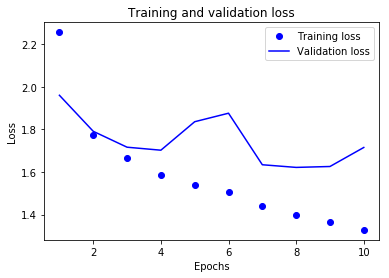

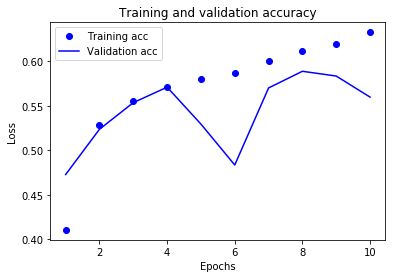

In [21]:
#LSTM Model
from keras.layers import LSTM
model = models.Sequential()
model.add(Embedding(max_features, 64))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(46, activation='softmax'))

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
time_start=time.clock()

#Train the model
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(input_test, y_test))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot model
#plot_model(model, show_shapes=True, to_file='LSTMmodel.png')

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 394s 44ms/step - loss: 2.2773 - acc: 0.4085 - val_loss: 1.9652 - val_acc: 0.4755
Epoch 2/10
8982/8982 [==============================] - 404s 45ms/step - loss: 1.7945 - acc: 0.5079 - val_loss: 1.7580 - val_acc: 0.5249
Epoch 3/10
8982/8982 [==============================] - 398s 44ms/step - loss: 1.9092 - acc: 0.4976 - val_loss: 1.7483 - val_acc: 0.5450
Epoch 4/10
8982/8982 [==============================] - 394s 44ms/step - loss: 1.5990 - acc: 0.5704 - val_loss: 1.7479 - val_acc: 0.5521
Epoch 5/10
8982/8982 [==============================] - 368s 41ms/step - loss: 1.5105 - acc: 0.5957 - val_loss: 1.7633 - val_acc: 0.5654
Epoch 6/10
8982/8982 [==============================] - 385s 43ms/step - loss: 1.4226 - acc: 0.6204 - val_loss: 1.8141 - val_acc: 0.5387
Epoch 7/10
8982/8982 [==============================] - 369s 41ms/step - loss: 1.3401 - acc: 0.6497 - val_loss: 1.8643 - val_acc: 

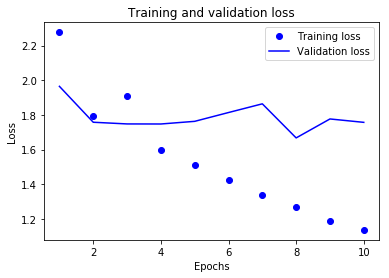

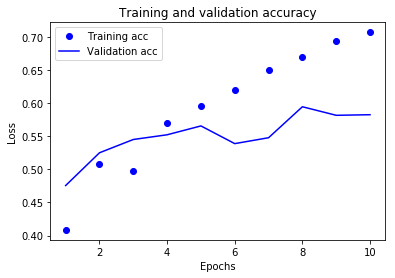

In [22]:
#GRUModel
from keras.layers import GRU
model = models.Sequential()
model.add(Embedding(max_features, 64))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(46, activation='softmax'))

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
time_start=time.clock()

#Train the model
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(input_test, y_test))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot model
#plot_model(model, show_shapes=True, to_file='GRUmodel.png')

In [4]:
#1D Convnet
model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(46, activation='softmax'))
model.summary()

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
import time
time_start=time.clock()

#Train the model
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(input_test, y_test))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot_model(model, show_shapes=True, to_file='1DCNNmodel.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 700,462
Trainable params: 700,462
Non-trainable params: 0
_________________________________________________________________
Trai

NameError: name 'plt' is not defined

In [17]:
#Combined 1D CNN and LSTM model
from keras.layers import LSTM
model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(46, activation='softmax'))

#Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

#Start computational clock
import time
time_start=time.clock()

#Train the model
history = model.fit(input_train, y_train, epochs=10, batch_size=128, 
                    validation_data=(input_test, y_test))

seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for model was:")
print("%d:%02d:%02d" % (h, m, s))

#Plot the training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the training and validation accuracy
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plot_model(model, show_shapes=True, to_file='1DCNNLSTMmodel.png')

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 225s 25ms/step - loss: 2.2786 - acc: 0.4047 - val_loss: 2.0126 - val_acc: 0.4314
Epoch 2/10
8982/8982 [==============================] - 222s 25ms/step - loss: 1.7823 - acc: 0.5315 - val_loss: 1.7757 - val_acc: 0.5347
Epoch 3/10
8982/8982 [==============================] - 223s 25ms/step - loss: 1.6506 - acc: 0.5734 - val_loss: 1.7908 - val_acc: 0.5548
Epoch 4/10
8982/8982 [==============================] - 227s 25ms/step - loss: 1.5498 - acc: 0.5998 - val_loss: 1.7106 - val_acc: 0.5512
Epoch 5/10
8982/8982 [==============================] - 231s 26ms/step - loss: 1.4640 - acc: 0.6230 - val_loss: 1.6629 - val_acc: 0.5730
Epoch 6/10
8982/8982 [==============================] - 223s 25ms/step - loss: 1.4041 - acc: 0.6348 - val_loss: 1.5937 - val_acc: 0.5966
Epoch 7/10
8982/8982 [==============================] - 220s 24ms/step - loss: 1.3593 - acc: 0.6466 - val_loss: 1.5904 - val_acc: 